# Generative

Modify a set of sequences to increase predicted accessibility.

In [ ]:
import numpy as np

In [2]:
import keras
import tensorflow as tf
import pyfaidx
import math
import pandas as pd
import tqdm
import scipy.stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from copy import deepcopy
import pyBigWig
from matplotlib.patches import Rectangle
from copy import deepcopy

Using TensorFlow backend.
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/s

In [3]:
from modisco.visualization import viz_sequence

In [4]:
from random import choice, sample
import sys

from keras.utils import CustomObjectScope

# mtbatchgen
sys.path.append("/users/surag/kundajelab/mtbatchgen/example/")
from losses import MultichannelMultinomialNLL, multinomial_nll

In [5]:
# local
from importlib import reload
import one_hot
reload(one_hot)

<module 'one_hot' from '/users/surag/kundajelab/scATAC-reprog/src/analysis/20210322_BPNet_synthetic/one_hot.py'>

In [6]:
from shaputils import *
import shap

In [ ]:
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx5/2020-11-05_03_48_37/KR1GbF.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20201105_all_peaks_filt256_in2346_out2000/cluster_idx4/extra_models/P2qbCl.h5")

    model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx2/2021-04-14_18_11_26/Dp2D6w.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
    model_neur = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/2021-04-14_18_11_26/QBF1UL.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx5/2021-04-14_18_11_26/nqv4wJ.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx8/2021-04-14_18_11_26/HhcfZk.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx1/2021-04-14_18_11_26/89fam2.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx14/2021-04-15_09_22_38/Y4lI6R.h5")
#     model = keras.models.load_model("/srv/scratch/surag/scATAC-reprog/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/2021-04-15_09_33_42/7zunw4.h5")

In [ ]:
hg38 = pyfaidx.Fasta('/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

In [ ]:
MODEL_INP_LEN = model.input_shape[0][1]
MODEL_OUT_LEN = model.output_shape[0][1]
print(MODEL_INP_LEN)
print(MODEL_OUT_LEN)

In [11]:
weightedsum_meannormed_logits = get_weightedsum_meannormed_logits(model)

profile_model_counts_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[1]],
         tf.reduce_sum(model.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer = shap.explainers.deep.TFDeepExplainer(
        ([model.input[0], model.input[2]], weightedsum_meannormed_logits),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

weightedsum_meannormed_logits_neur = get_weightedsum_meannormed_logits(model_neur)

profile_model_counts_explainer_neur = shap.explainers.deep.TFDeepExplainer(
        ([model_neur.input[0], model_neur.input[1]],
         tf.reduce_sum(model_neur.outputs[1], axis=-1)),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

profile_model_profile_explainer_neur = shap.explainers.deep.TFDeepExplainer(
        ([model_neur.input[0], model_neur.input[2]], weightedsum_meannormed_logits_neur),
        shuffle_several_times,
        combine_mult_and_diffref=combine_mult_and_diffref)

## Peak Sets

In [14]:
peak_set = pd.read_csv("../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.bed", 
                           sep='\t',
                           names=["chr", "start", "end"])
peak_set["mid"] = (peak_set["start"] + peak_set["end"])//2
peak_set.head()

,chr,start,end,mid
0,chr1,839897,840397,840147
1,chr1,1801493,1802694,1802093
2,chr1,2118733,2119234,2118983
3,chr1,2349814,2350613,2350213
4,chr1,3803335,3803835,3803585


In [1023]:
BATCH_SIZE = 128

# predict on raw sequence
raw_pred_counts = []

for i in tqdm.tqdm(range(math.ceil(peak_set.shape[0]/BATCH_SIZE))):
    cur_seqs = peak_set[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in cur_seqs.iterrows():
        cur_raw_seqs.append(str(hg38[r['chr']][r['mid']-(MODEL_INP_LEN//2):r['mid']+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    raw_pred_counts.append(cur_pred)
    
raw_pred_counts = np.vstack(raw_pred_counts).ravel()

100%|██████████| 179/179 [00:52<00:00,  3.38it/s]


In [1028]:
# C2 peak set 8
np.quantile(raw_pred_counts, [0.25,.5,.75, .9, .99])

array([4.23649383, 4.68817472, 5.16638064, 5.58655987, 6.29527551])

In [1017]:
# C2 peak set 11
np.quantile(raw_pred_counts, [0.25,.5,.75, .9,.99])

array([5.52469528, 5.90524507, 6.27489841, 6.60772095, 7.21408137])

In [18]:
# C2 peak set 13
np.quantile(raw_pred_counts, [0.25,.5,.75, .9,.99])

array([5.89582646, 6.29021645, 6.67966914, 7.05824156, 7.76616339])

In [852]:
# high OSK peak set 8
np.quantile(raw_pred_counts, [0.01, 0.1, 0.25,.5,.75, .9,.99])

array([2.34164679, 3.29097555, 3.75607044, 4.20493579, 4.58417916,
       4.87113447, 5.31229448])

In [855]:
# high OSK peak set 11
np.quantile(raw_pred_counts, [0.01, 0.1, 0.25,.5,.75, .9,.99])

array([2.15232193, 3.1831604 , 3.73889768, 4.26644588, 4.67327476,
       4.97796226, 5.48127816])

In [877]:
# rand
IDX = choice(range(peak_set.shape[0]))
print(IDX)

16377


In [878]:
locus = peak_set.iloc[IDX]["chr"] + ":" + str(peak_set.iloc[IDX]["start"]) + "-" + str(peak_set.iloc[IDX]["end"])
locus

'chr5:72290099-72290886'

In [879]:
seq = str(hg38[peak_set.iloc[IDX]['chr']][peak_set.iloc[IDX]['mid']-(MODEL_INP_LEN//2):peak_set.iloc[IDX]['mid']+(MODEL_INP_LEN//2)])

In [880]:
X = one_hot.dna_to_one_hot([seq])

In [881]:
# GC content of center 500 bp
np.sum(X[0, 923:1423, 1:3])/500

0.4

In [882]:
model.predict([X, 
               np.zeros((X.shape[0],1)), 
               np.zeros((X.shape[0],2000,2))])[1]

array([[5.108671]], dtype=float32)

In [883]:
model_neur.predict([X, 
               np.zeros((X.shape[0],1)), 
               np.zeros((X.shape[0],2000,2))])[1]

array([[5.0321302]], dtype=float32)

In [884]:
counts_shap_scores_neur = profile_model_counts_explainer_neur.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores_neur = np.multiply(X, counts_shap_scores_neur[0])

Done 0 examples of 1


In [885]:
counts_shap_scores = profile_model_counts_explainer.shap_values(
        [X, np.zeros((X.shape[0], 1))], progress_message=100)
projected_shap_scores = np.multiply(X, counts_shap_scores[0])

Done 0 examples of 1


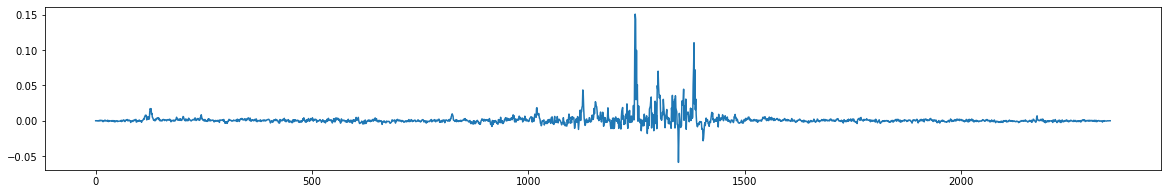

In [886]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(MODEL_INP_LEN), np.sum(projected_shap_scores_neur[0], axis=1))
plt.show()

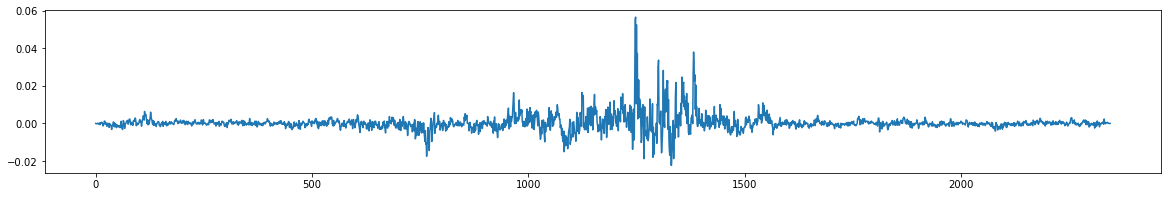

In [887]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(range(MODEL_INP_LEN), np.sum(projected_shap_scores[0], axis=1))
plt.show()

In [888]:
def get_imp_intervals(shap_scores, top_val=8, extend=4):
    scores = np.sum(shap_scores, axis=1)
    top_pos = np.argsort(scores)[::-1][:top_val]
    extended_pos = sorted(list(set(sum([list(range(x-extend,x+extend)) for x in top_pos], []))))
    return extended_pos

In [889]:
imp_intervals_neur = get_imp_intervals(projected_shap_scores_neur[0])
imp_intervals_neur

[1242,
 1243,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1250,
 1251,
 1252,
 1253,
 1296,
 1297,
 1298,
 1299,
 1300,
 1301,
 1302,
 1303,
 1378,
 1379,
 1380,
 1381,
 1382,
 1383,
 1384,
 1385,
 1386,
 1387,
 1388]

In [890]:
START = min(imp_intervals_neur) - 50
END = max(imp_intervals_neur) + 50

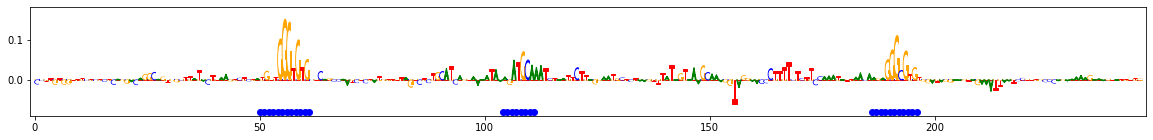

In [891]:
_, ax = plt.subplots(figsize=(20,2))

viz_sequence.plot_weights_given_ax(ax, projected_shap_scores_neur[0][START:END], subticks_frequency=50)
ymin, _ = ax.get_ylim()

for x in imp_intervals_neur:
    ax.scatter(x-START, ymin+0.01, c='b')

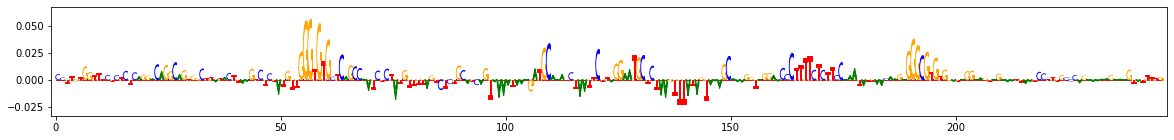

In [892]:
viz_sequence.plot_weights(projected_shap_scores[0][START:END], subticks_frequency=50)

### Optimizing a sequence

In [893]:
BASES = ["A", "C", "G", "T"]

def beam_optimize(model, seq, n_steps, pos_to_mut, beamsize=10):
    # optimize seq (1 x INLEN x 4) for n_steps with ISM within limits
    init_cts = model.predict([seq, 
                               np.zeros((seq.shape[0],1)), 
                               np.zeros((seq.shape[0],2000,2))])[1][0][0]
    
    beam = [([init_cts], [], [], seq)]
    num_pos = len(pos_to_mut)
    
    mask = np.zeros((num_pos, seq.shape[1]))
    
    for i in range(num_pos):
        mask[i, pos_to_mut[i]] = 1
    
    for _ in tqdm.tqdm(range(n_steps)):
        next_beam = []
        
        for cur_cts, cur_poses, cur_bases, cur_seq in beam:
            mod_cts = []
            
            for base in range(4):
                z = np.zeros(4)
                z[base] = 1
                
                batch = cur_seq.repeat(num_pos, axis=0)
                batch[mask>0] = z
                
                batch_cts = model.predict([batch, 
                                           np.zeros((batch.shape[0],1)), 
                                           np.zeros((batch.shape[0],2000,2))])[1]
                
                next_beam += [(cur_cts + [batch_cts[idx][0]], 
                               cur_poses + [pos], 
                               cur_bases +[base], 
                               batch[idx:idx+1]) \
                              for idx,pos in enumerate(pos_to_mut)]
        # prune beam

        # first dedup to remove those with same set of mutations
        beam = []
        uniq_pos_base = set()
        
        for x in next_beam:
            key = tuple(sorted(list(zip(x[1], x[2]))))
            if key not in uniq_pos_base:
                uniq_pos_base.add(key)
                beam.append(x)
        
        beam = sorted(beam, key=lambda x:-x[0][-1])
        beam = beam[:beamsize]
    
    return beam

In [894]:
# beam = beam_optimize(model, X.copy(), 4, list(range(START, END)), 10)
beam = beam_optimize(model, X.copy(), 3, imp_intervals_neur, 10)

100%|██████████| 3/3 [00:05<00:00,  1.84s/it]


In [895]:
# beam_neur = beam_optimize(model_neur, X.copy(), 4, list(range(START, END)), 10)
beam_neur = beam_optimize(model_neur, X.copy(), 3, imp_intervals_neur, 10)

100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


In [896]:
TO_VIZ = 0

In [897]:
modseq = X.copy()

for i in range(len(beam[TO_VIZ][1])):
    z = np.zeros(4)
    z[beam[TO_VIZ][2][i]] = 1
    
    modseq[0][beam[TO_VIZ][1][i]] = z

In [898]:
modseq_neur = X.copy()

for i in range(len(beam_neur[TO_VIZ][1])):
    z = np.zeros(4)
    z[beam_neur[TO_VIZ][2][i]] = 1
    
    modseq_neur[0][beam_neur[TO_VIZ][1][i]] = z

In [899]:
modcts = model.predict([modseq, 
                     np.zeros((modseq.shape[0],1)), 
                     np.zeros((modseq.shape[0],2000,2))])[1][0][0]

print(modcts, beam[TO_VIZ][0][-1])
mod_counts_shap_scores = profile_model_counts_explainer.shap_values(
        [modseq, np.zeros((modseq.shape[0], 1))], progress_message=100)
mod_projected_shap_scores = np.multiply(modseq, mod_counts_shap_scores[0])

6.693241 6.6932406
Done 0 examples of 1


In [900]:
model_pred_for_modseq_neur = model.predict([modseq_neur, 
                                            np.zeros((modseq_neur.shape[0],1)), 
                                            np.zeros((modseq_neur.shape[0],2000,2))])[1][0][0]
model_pred_for_modseq_neur

6.693241

In [901]:
modcts_neur = model_neur.predict([modseq_neur, 
                             np.zeros((modseq_neur.shape[0],1)), 
                             np.zeros((modseq_neur.shape[0],2000,2))])[1][0][0]

print(modcts_neur, beam_neur[TO_VIZ][0][-1])
mod_counts_shap_scores_neur = profile_model_counts_explainer_neur.shap_values(
        [modseq_neur, np.zeros((modseq_neur.shape[0], 1))], progress_message=100)
mod_projected_shap_scores_neur = np.multiply(modseq_neur, mod_counts_shap_scores_neur[0])

5.527054 5.5270553
Done 0 examples of 1


In [902]:
model_neur.predict([modseq, 
                    np.zeros((modseq_neur.shape[0],1)), 
                    np.zeros((modseq_neur.shape[0],2000,2))])[1][0][0]

5.527054

In [903]:
# ctr=2

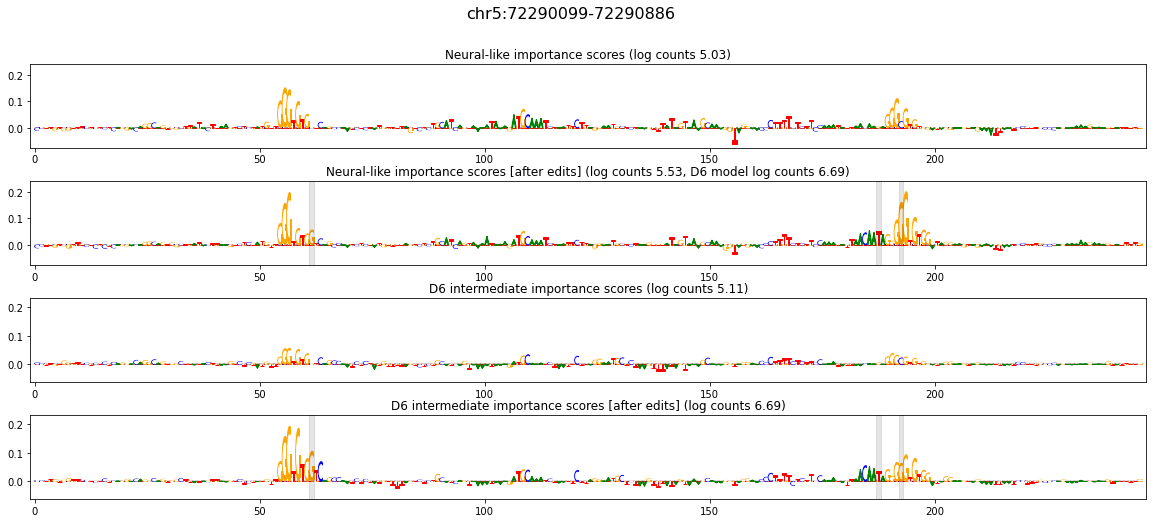

In [904]:
fig, axs = plt.subplots(4,1, figsize=(20,8))

start = START
end = END
viz_sequence.plot_weights_given_ax(axs[0], 
                                   projected_shap_scores_neur[0][start:end], 
                                   subticks_frequency=50)
axs[0].set_title("Neural-like importance scores (log counts {:.2f})".format(beam_neur[TO_VIZ][0][0]))

viz_sequence.plot_weights_given_ax(axs[1], 
                                   mod_projected_shap_scores_neur[0][start:end], 
                                   subticks_frequency=50)
axs[1].set_title("Neural-like importance scores [after edits] (log counts {:.2f}, D6 model log counts {:.2f})".format(beam_neur[TO_VIZ][0][-1],
                                                                                                                      model_pred_for_modseq_neur))

viz_sequence.plot_weights_given_ax(axs[2], 
                                   projected_shap_scores[0][start:end], 
                                   subticks_frequency=50)
axs[2].set_title("D6 intermediate importance scores (log counts {:.2f})".format(beam[TO_VIZ][0][0]))

viz_sequence.plot_weights_given_ax(axs[3], 
                                   mod_projected_shap_scores[0][start:end], 
                                   subticks_frequency=50)
axs[3].set_title("D6 intermediate importance scores [after edits] (log counts {:.2f})".format(beam[TO_VIZ][0][-1]))

l1,u1 = axs[1].get_ylim()
axs[0].set_ylim((l1,u1))

l2,u2 = axs[3].get_ylim()
axs[2].set_ylim((l2,u2))

fig.suptitle(locus, fontsize=16)

for i in range(len(beam_neur[TO_VIZ][1])):
    axs[1].add_patch(Rectangle((beam_neur[TO_VIZ][1][i]-start,l1), 1, u1-l1, color="k", alpha=0.1))

for i in range(len(beam[TO_VIZ][1])):
    axs[3].add_patch(Rectangle((beam[TO_VIZ][1][i]-start,l2), 1, u2-l2, color="k", alpha=0.1))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
# plt.savefig("snippets/{}.pdf".format(ctr))
# ctr+=1

In [905]:
tmpseq = modseq_neur.copy()
# tmpseq = X.copy()

In [652]:
tmpseq[0][START+200+23:START+200+30]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]])

In [653]:
tmpseq[0][START+200+77:START+200+82]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [654]:
tmpseq[0][START+200+120:START+200+130]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [655]:
tmpseq[0][START+200+286:START+200+295]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [656]:
tmpseq[0][START+200+23] = [1,0,0,0]
tmpseq[0][START+200+24] = [1,0,0,0]
tmpseq[0][START+200+80] = [0,0,1,0]
tmpseq[0][START+200+81] = [0,0,1,0]
tmpseq[0][START+200+122] = [0,0,1,0]
tmpseq[0][START+200+123] = [0,0,1,0]
tmpseq[0][START+200+289] = [0,0,1,0]
tmpseq[0][START+200+290] = [0,0,1,0]

In [657]:
print(model.predict([modseq_neur, 
                     np.zeros((modseq.shape[0],1)), 
                     np.zeros((modseq.shape[0],2000,2))])[1][0][0])
print(model.predict([tmpseq, 
                     np.zeros((modseq.shape[0],1)), 
                     np.zeros((modseq.shape[0],2000,2))])[1][0][0])

5.6798863
5.5935483


In [360]:
print(model_neur.predict([modseq_neur, 
                     np.zeros((modseq.shape[0],1)), 
                     np.zeros((modseq.shape[0],2000,2))])[1][0][0])
print(model_neur.predict([tmpseq, 
                     np.zeros((modseq.shape[0],1)), 
                     np.zeros((modseq.shape[0],2000,2))])[1][0][0])

4.723495
3.519866


In [129]:
print(beam[TO_VIZ][0])
print([x-start for x in beam[TO_VIZ][1]])

[5.3809276, 5.8465185, 6.3009987, 6.541591]
[74, 62, 240]


## Motif Preferences

Introduce KLF4 consensus motif in random sequences. Then try for N=1 (maybe 2) mutations in KLF4 motif and measure how the predicted counts decreases with different mutations for different models.

In [81]:
from random import shuffle, choice, random
from copy import deepcopy

In [82]:
oct_sox_hits = pd.read_csv("./data/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx8.200.OCTSOX.thresh7.bed", 
                           sep='\t',
                           names=["chr", "start", "end", "strand", "score", "seq"])
oct_sox_hits.head()

,chr,start,end,strand,score,seq
0,chr1,2350165,2350180,+,7.492762,CTTTGAATATAAAAT
1,chr1,5940748,5940763,+,8.132912,ATCTACATTTTAAAA
2,chr1,7263287,7263302,-,12.820701,CTTTCTTTTGCAAAT
3,chr1,7843523,7843538,-,7.100240,TTTTGTTTTTAAAAT
4,chr1,9756154,9756169,-,7.883148,ATTTCACATGAAAAT


In [83]:
random_positions = [(choice(["chr"+str(x) for x in range(1,23)]), int(random()*4e7)) for _ in range(64*2)]

# or from oct_sox_hits from a peak set 
# random_positions = [(x["chr"],x["start"]) for _,x in oct_sox_hits.sample(64).iterrows()]

In [114]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts = []
random_pred_counts_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts.append(cur_pred)
    
    cur_pred_neur = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts_neur.append(cur_pred_neur)
    
random_pred_counts = np.vstack(random_pred_counts).ravel()
random_pred_counts_neur = np.vstack(random_pred_counts_neur).ravel()

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [115]:
print(np.median(random_pred_counts))
print(np.median(random_pred_counts_neur))

4.4307575
2.032946


In [116]:
from itertools import combinations, product

def all_muts(s, n):
    muts = [s]
    subs = [[y for y in ["A","C","G","T"] if y!=x] for x in s]
    
    for x in combinations(range(len(s)), n):
        cur_subs = product(*[subs[y] for y in x])
        
        for bases in cur_subs:
            cur_str = ""
            j = 0
            for i in range(len(x)):                
                cur_str += s[j:x[i]] + bases[i]
                j = x[i]+1
            cur_str += s[j:]

            muts.append(cur_str)
    
    return muts

In [102]:
all_KLF_one_muts = all_muts("GCCACACCCA",1)
all_OS_one_muts = all_muts("ATTTGCATAACAATG",1)
all_O_one_muts = all_muts("ATTTGCATAA",1)
print(len(all_KLF_one_muts))
print(len(all_OS_one_muts))
print(len(all_O_one_muts))

31
46
31


In [157]:
all_KLF_two_muts = all_muts("GCCACACCCA",2)
all_OS_two_muts = all_muts("ATTTGCATAACAATG",2)
all_O_two_muts = all_muts("ATTTGCATAA",2)
print(len(all_KLF_two_muts))
print(len(all_OS_two_muts))
print(len(all_O_two_muts))

406
946
406


In [185]:
all_OS_tail_muts = [x+"GCATAACAATG" for x in sum([all_muts("ATTT", i) for i in range(1,5)], [])]
all_OS_GCAT_muts = ["ATTT"+x +"AACAATG" for x in sum([all_muts("GCAT", i) for i in range(1,5)], [])]
all_OS_ACAAT_muts = ["ATTTGCATA"+x + "G" for x in sum([all_muts("ACAAT", i) for i in range(1,6)], [])]
print(len(all_OS_tail_muts))
print(len(all_OS_GCAT_muts))
print(len(all_OS_ACAAT_muts))

259
259
1028


In [196]:
REPLACE_WITH = all_OS_GCAT_muts # all_OS_two_muts + all_OS_one_muts
REPLACE_WITH_WID = 15

In [197]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts_muts = []
synth_pred_counts_muts_neur = []

        
motif_start = MODEL_INP_LEN//2 
motif_end = MODEL_INP_LEN//2 + REPLACE_WITH_WID


for i in tqdm.tqdm(range(len(random_positions))):
    cur_seq = random_positions[i]
    cur_raw_seqs = []
    cur_seq = str(hg38[cur_seq[0]][cur_seq[1]-(MODEL_INP_LEN//2):cur_seq[1]+(MODEL_INP_LEN//2)])
    
    for j, r in enumerate(REPLACE_WITH):
        cur_raw_seqs.append(cur_seq[:motif_start] +  r + cur_seq[motif_end:])
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts_muts.append(cur_pred)
    
    cur_pred_neur = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts_muts_neur.append(cur_pred_neur)

100%|██████████| 128/128 [02:19<00:00,  1.09s/it]


In [198]:
deltas = np.squeeze(np.array(synth_pred_counts_muts)) - np.expand_dims(random_pred_counts, axis=1)
deltas_neur = np.squeeze(np.array(synth_pred_counts_muts_neur)) - np.expand_dims(random_pred_counts_neur, axis=1)

deltas_mean = np.mean(deltas, axis=0)
deltas_mean_neur = np.mean(deltas_neur, axis=0)

In [199]:
deltas_mean

array([ 8.84050250e-01,  8.59244466e-01,  7.32281089e-01,  5.91573536e-01,
        8.06764662e-01,  5.87602019e-01,  7.12043583e-01,  6.56922758e-01,
        7.47979641e-01,  6.58667207e-01,  8.13403904e-01,  7.60753870e-01,
        5.95188677e-01,  8.84050250e-01,  7.65736341e-01,  5.13190746e-01,
        4.96916652e-01,  6.36788130e-01,  3.40244293e-01,  3.99612844e-01,
        5.38176954e-01,  2.65023381e-01,  2.08565757e-01,  5.35335004e-01,
        6.92222774e-01,  5.80411732e-01,  5.18874586e-01,  5.09183586e-01,
        4.59803432e-01,  2.48126149e-01,  3.33093047e-01,  2.27284163e-01,
        7.54816353e-01,  7.95020044e-01,  5.22794127e-01,  4.55907404e-01,
        5.48769772e-01,  2.26315022e-01,  3.00525725e-01,  3.46900493e-01,
        1.34143129e-01,  5.00132620e-01,  4.53506470e-01,  4.33279902e-01,
        3.10357034e-01,  2.52040505e-01,  2.85662740e-01,  3.08326215e-01,
        4.69192684e-01,  4.40525115e-01,  5.23825884e-01,  3.94812524e-01,
        2.68314630e-01,  

In [200]:
i = REPLACE_WITH.index("ATTTGCATAACAATG")
print(deltas_mean[i], deltas_mean_neur[i])

0.88405025 0.5113408


In [201]:
from adjustText import adjust_text

In [202]:
scipy.stats.spearmanr(deltas_mean, deltas_mean_neur)

SpearmanrResult(correlation=0.892567714574822, pvalue=7.037445243039541e-91)

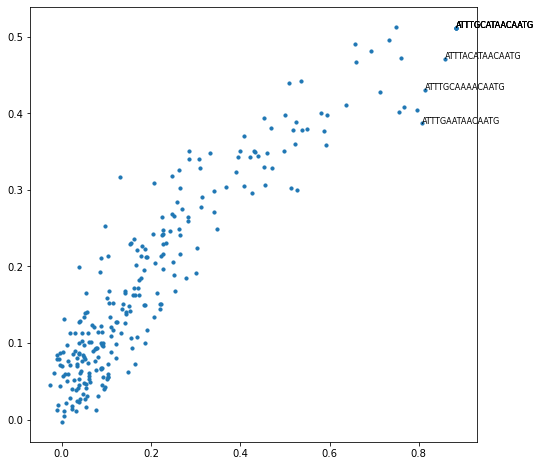

In [205]:
plt.rcParams["figure.figsize"] = (8,8)

# x = np.argsort(np.argsort(deltas_mean))
# y = np.argsort(np.argsort(deltas_mean_neur))
x = deltas_mean
y = deltas_mean_neur

plt.scatter(x, y, s=10)

texts = [plt.text(x[i], y[i], txt, fontsize=8) for i,txt in enumerate(REPLACE_WITH) if x[i]>0.8] # or x[i] > .78 or y[i] <0.25]#
#         if (x[i]<300 and y[i]>600)  or (y[i]<300 and x[i]>800)]
# adjust_text(texts)

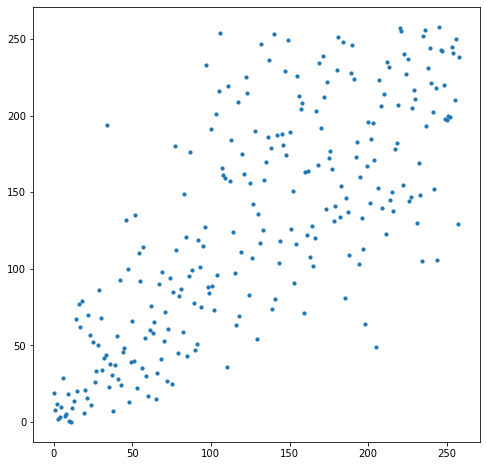

In [194]:
plt.rcParams["figure.figsize"] = (8,8)

x = np.argsort(np.argsort(deltas_mean))
y = np.argsort(np.argsort(deltas_mean_neur))
# x = deltas_mean
# y = deltas_mean_neur

plt.scatter(x, y, s=10)

# texts = [plt.text(x[i], y[i], txt, fontsize=8) for i,txt in enumerate(REPLACE_WITH) if y[i]<-0.051]
#         if (x[i]<300 and y[i]>600)  or (y[i]<300 and x[i]>800)]
# adjust_text(texts)

In [45]:
def get_delta_proj(deltas, mut_strs):
    deltas_proj = one_hot.dna_to_one_hot(mut_strs)
    orig = deltas_proj[0].copy()
    tot_cts = np.zeros(orig.shape)
    
    for i in range(len(mut_strs)):
        deltas_proj[i] -= orig # remove orignal seq
        deltas_proj[i][deltas_proj[i] < 0] = 0 # set non-matching to zero -- now only changed bases
        tot_cts += deltas_proj[i]
        deltas_proj[i] *= deltas[i]

    deltas_proj = -np.nan_to_num(np.sum(deltas_proj, axis=0)/tot_cts)
    deltas_proj += (orig*deltas[0])
    
    return deltas_proj

deltas_proj = get_delta_proj(deltas_mean, REPLACE_WITH)
deltas_proj_neur = get_delta_proj(deltas_mean_neur, REPLACE_WITH)

/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


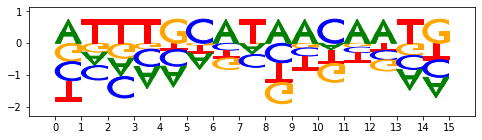

In [46]:
viz_sequence.plot_weights(deltas_proj, figsize=(8,2))

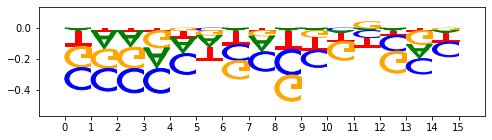

In [47]:
viz_sequence.plot_weights(deltas_proj_neur, figsize=(8,2))

## Marginalize Motif

In [108]:
from random import shuffle, choice, random
from copy import deepcopy

In [116]:
random_positions = [(choice(["chr"+str(x) for x in range(1,23)]), int(random()*4e7)) for _ in range(128*10)]

In [117]:
# or choose from weak motif hits from a peak set
# random_positions = [(x["chr"],x["start"]) for _,x in oct_sox_hits.sample(128).iterrows()]

In [411]:
BATCH_SIZE = 128

# replace with canonical motif and predict
random_pred_counts = []
random_pred_counts_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts.append(cur_pred)
    
    cur_pred = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    random_pred_counts_neur.append(cur_pred)
    
random_pred_counts = np.vstack(random_pred_counts).ravel()
random_pred_counts_neur = np.vstack(random_pred_counts_neur).ravel()

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


In [119]:
def mod_sequence(s, rep, motif_start, motif_end):
    return s[:motif_start] + rep + s[motif_end:] #  + "CCACCC" + s[motif_end+26:motif_end+46] +\
#                               "CCACCC" + s[motif_end+52:motif_end+72]  +"CCACCC" +  s[motif_end+78:motif_end+100] + \
#                               "CCACCC" + s[motif_end+88:motif_end+108] +"ACAAAA" +  s[motif_end+114:motif_end+134] + \
#                               "ACAAAA" + s[motif_end+140:motif_end+160] +"TGACTCA" +  s[motif_end+167:motif_end+185] +\
#                                "TGACTCA" +  s[motif_end+192:] 

In [451]:
from random import choice, randint

In [497]:
TO_ADD_MIX = [(choice(["AACAAAG","CTTTGTT"]), randint(20,40)) for _ in range(6)] + \
         [("ATTTGCATAACAAAG", 32)] + \
         [(choice(["AACAAAG","CTTTGTT"]), randint(20,40)) for _ in range(8)]

TO_ADD_OS = [("ATTTGCATAACAAAG", 0)]

def mod_sequence2(s, start, to_add):
    cur = s[:start]
    
    i = start
    for x in to_add:
        cur += x[0]
        cur += s[i+len(x[0]):i+len(x[0])+x[1]]
        i = i+len(x[0])+x[1]
    
    cur += s[i:]
    
    return cur

In [499]:
TO_ADD_DEL1 = deepcopy(TO_ADD_MIX)
TO_ADD_DEL1[2] = ("GAGTTAG", TO_ADD_MIX[2][1])

TO_ADD_DEL2 = deepcopy(TO_ADD_DEL1)
TO_ADD_DEL2[-3] = ("AGGTTAG", TO_ADD_DEL1[-3][1])

In [1]:
BATCH_SIZE = 128

# replace with canonical motif and predict
synth_pred_counts = []
synth_pred_counts_neur = []

for i in tqdm.tqdm(range(math.ceil(len(random_positions)/BATCH_SIZE))):
    cur_seqs = random_positions[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    cur_raw_seqs = []
    for j, r in enumerate(cur_seqs):
        cur_raw_seqs.append(str(hg38[r[0]][r[1]-(MODEL_INP_LEN//2):r[1]+(MODEL_INP_LEN//2)]))
        
#         replacement = "ATTTGCATAACAAAG" #"TTTTCAAATGTTGAA"

#         motif_start = MODEL_INP_LEN//2         
#         motif_end = MODEL_INP_LEN//2 + len(replacement)
        
#         cur_raw_seqs[-1] = mod_sequence(cur_raw_seqs[-1], replacement, motif_start, motif_end)
#         cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2-200, TO_ADD_DEL2)
#         cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2-100, TO_ADD_OS)
#         cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2+200, [("GCCACGCCC", 0)])
        cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2, [("TGGGTGTGGC", 0)])
#         cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2+50, [("GGGGTGTGG", 0)])    
        # SOX-KLF ACAATAGGGGGTGTGG
#         cur_raw_seqs[-1] = mod_sequence2(cur_raw_seqs[-1], MODEL_INP_LEN//2-300, TO_ADD_OS)

    cur_raw_seqs = one_hot.dna_to_one_hot(cur_raw_seqs)
    
    cur_pred = model.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts.append(cur_pred)
    
    cur_pred = model_neur.predict([cur_raw_seqs, 
                   np.zeros((cur_raw_seqs.shape[0],1)), 
                   np.zeros((cur_raw_seqs.shape[0],2000,2))])[1]
    synth_pred_counts_neur.append(cur_pred)
    
synth_pred_counts = np.vstack(synth_pred_counts).ravel()
synth_pred_counts_neur = np.vstack(synth_pred_counts_neur).ravel()

NameError: name 'tqdm' is not defined

In [574]:
np.median(random_pred_counts), np.median(random_pred_counts_neur)

(4.1888323, 2.047305)

In [918]:
# SOX only
np.median(synth_pred_counts), np.median(synth_pred_counts_neur)

(4.265724, 2.167384)